# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore");


from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import random

In [3]:
#открываю файл, смотрю пропуски и дубликаты
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')
display(df1)

#print(df1.isna().sum())
#print(df2.isna().sum())
#print(df3.isna().sum())
#df1.info()
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()
df3 = df3.drop_duplicates()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [4]:
#функция для фичей и таргета
def f_t(df):
    features = df.drop(['product','id'], axis=1)
    target = df['product']
    return features, target

features_1, target_1 = f_t(df1)
features_2, target_2 = f_t(df2)
features_3, target_3 = f_t(df3)

## Обучение и проверка модели

In [5]:
#разделим на обучающую и тестовую выборки
def train_test(features, target, test):
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                test_size=test, random_state=12345)
#    print('Размер обучающей выборки:', features_train.shape[0],'объектов')
#    print('Размер тестовой выборки:',features_test.shape[0],'объекта')
    return features_train, features_test, target_train, target_test

features_train_1, features_test_1, target_train_1, target_test_1 =  train_test(features_1, target_1, 0.25)
features_train_2, features_test_2, target_train_2, target_test_2 =  train_test(features_2, target_2, 0.25)
features_train_3, features_test_3, target_train_3, target_test_3 =  train_test(features_3, target_3, 0.25)

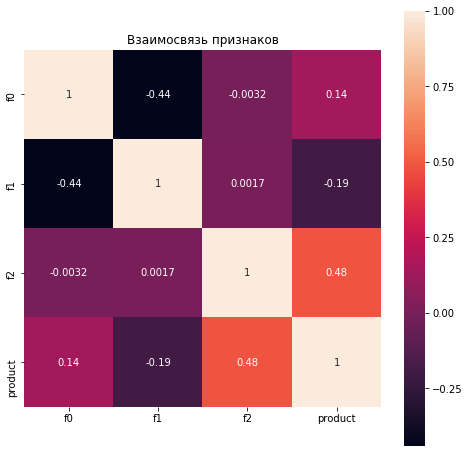

In [6]:
#Проверка на мультикоолинеарность, по условию задачи на это не обращаем внимание
def corr(df):
    columns = df.columns
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df[columns].corr(), square=True, ax=ax, annot = True);
    plt.title('Взаимосвязь признаков');

corr(df1)
#corr(df2)
#corr(df3)

In [10]:
#стандартизируем
def scaler(features_train, features_test):
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_scaled = scaler.transform(features_train)
    features_test_scaled = scaler.transform(features_test)
    return features_train_scaled, features_test_scaled

features_train_1, features_test_1 = scaler(features_train_1, features_test_1)
features_train_2, features_test_2 = scaler(features_train_2, features_test_2)
features_train_3, features_test_3 = scaler(features_train_3, features_test_3)

In [11]:
#Создаю модель и делаю предсказание
def LR_model(features_train, target_train, features_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_test)
    pred_mean = prediction.mean()
    
    return prediction, pred_mean, model

In [12]:
#расчет метрик
def metrics(target, prediction):
    rmse = np.sqrt(mean_squared_error(target, prediction))
    r_2 = r2_score(target, prediction)
    mae = mean_absolute_error(target, prediction)
    
    return rmse, r_2, mae

In [13]:
#вывод метрик на экран
def metrics_out(target, prediction, pred_mean):
    rmse, r_2, mae = metrics(target, prediction)
    df_metrics = pd.DataFrame(data= [rmse,r_2, mae, pred_mean], index= ['RMSE','r_2',
                                                                       'MAE', 'Pred_mean']).T
    return df_metrics

In [14]:
#расчет метрик для регионов
df1_prediction, df1_pred_mean, df1_model = LR_model(features_train_1, target_train_1, features_test_1)
metrics_out(target_test_1, df1_prediction, df1_pred_mean)

,RMSE,r_2,MAE,Pred_mean
0,37.579422,0.279943,30.919601,92.592568


In [15]:
df2_prediction, df2_pred_mean, df2_model = LR_model(features_train_2, target_train_2, features_test_2)
metrics_out(target_test_2, df2_prediction, df2_pred_mean)

,RMSE,r_2,MAE,Pred_mean
0,0.893099,0.999623,0.718766,68.728547


In [16]:
df3_prediction, df3_pred_mean, df3_model = LR_model(features_train_3, target_train_3, features_test_3)
metrics_out(target_test_3, df3_prediction, df3_pred_mean)

,RMSE,r_2,MAE,Pred_mean
0,40.029709,0.205248,32.792652,94.965046


# Промежуточный итог
Метрики в регионе 2 значительно выше остальных, модель этого региона имеет лучшую точность.
Коэффициент f2 имеет наибольший вес во всех регионах.
Регионы 1 и 3 имеют приблизительно одинаковые значения RMSE Mae.


## Подготовка к расчёту прибыли

In [18]:
#значения для расчетов
points = 500
best_points = 200
budget = 10e9
barrel_income = 450000

In [19]:
# минимальный обьем для работы скважины
min_value = budget/barrel_income/best_points
print('Достаточный объём сырья для безубыточной разработки новой скважины %.2f'
      %min_value,'тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей


In [20]:
difference_1 = (1 - df1_pred_mean/min_value)*100
difference_2 = (1 - df2_pred_mean/min_value)*100
difference_3 = (1 - df3_pred_mean/min_value)*100

print('Средний обьем скважины для региона df1 меньше минимального на %.2f'
      %difference_1,'%')
print('Средний обьем скважины для региона df2 меньше минимального на %.2f'
      %difference_2,'%')
print('Средний обьем скважины для региона df3 меньше минимального на %.2f'
      %difference_3,'%')

Средний обьем скважины для региона df1 меньше минимального на 16.67 %
Средний обьем скважины для региона df2 меньше минимального на 38.14 %
Средний обьем скважины для региона df3 меньше минимального на 14.53 %


## Расчёт прибыли и рисков 

In [64]:
def tp_df(target, prediction):
    df = pd.DataFrame(prediction)
    df.index = target.index
    df = df.join(target)
    df = df.rename(columns={0:'predict', 'product':'target'})
    return df

df1_tp = tp_df(target_test_1, df1_prediction)
df2_tp = tp_df(target_test_2, df2_prediction)
df3_tp = tp_df(target_test_3, df3_prediction)

In [65]:
df1_top200 = df1_tp.sort_values(by='predict', ascending=False).head(200)
df2_top200 = df2_tp.sort_values(by='predict', ascending=False).head(200)
df3_top200 = df3_tp.sort_values(by='predict', ascending=False).head(200)


In [66]:
def income_profit(df):
    income = df.target.sum()*barrel_income
    profit = income - budget
    print('Доход в регионе: %.2f'%(income/1000), 'тыс. рублей')
    print('Прибыль в регионе: %.2f'%(profit/1000), 'тыс. рублей')
    return income, profit

In [67]:
income_profit_df1 = income_profit(df1_top200)

Доход в регионе: 13320826.04 тыс. рублей
Прибыль в регионе: 3320826.04 тыс. рублей


In [68]:
income_profit_df2 = income_profit(df2_top200)

Доход в регионе: 12415086.70 тыс. рублей
Прибыль в регионе: 2415086.70 тыс. рублей


In [69]:
income_profit_df3 = income_profit(df3_top200)

Доход в регионе: 12710349.96 тыс. рублей
Прибыль в регионе: 2710349.96 тыс. рублей


# Вывод
Лучшие показатели прибыли в регионе 1

### Риски и прибыль по регионам

In [70]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    profit = (selected.sum()*barrel_income-budget)
    return profit

In [71]:
state = np.random.RandomState(12345)
def bootstrap(data, N, count):
    target = data.target
    probabilities = data.predict
    
    values = []
    for i in range(1000):
        target_subsample = target.sample(n = N, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index] 
        values.append(revenue(target_subsample, probs_subsample,count))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean = values.mean()/1000
    print("Средняя прибыль:", mean,'тыс.рублей')
    print('95%-доверительный интервал от: {:.2f}'.format(lower/1000), 'до {:.2f}'.format(upper/1000), 'тыс.рублей')
    return values

In [72]:
df1_values = bootstrap(df1_tp, 500,200)

Средняя прибыль: 425938.52691059234 тыс.рублей
95%-доверительный интервал от: -102090.09 до 947976.35 тыс.рублей


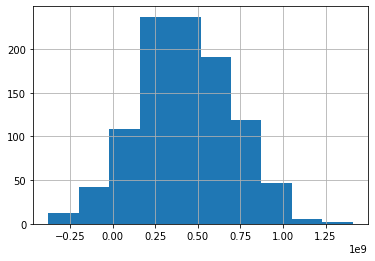

In [73]:
df1_values.hist()

In [27]:
df2_values = bootstrap(df2_tp, 500,200)

Средняя прибыль: 518259.49369732494 тыс.рублей
95%-доверительный интервал от: 128123.23 до 953612.98 тыс.рублей


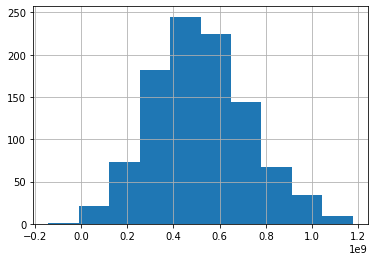

In [28]:
df2_values.hist()

In [74]:
df3_values = bootstrap(df3_tp, 500,200)

Средняя прибыль: 426649.3222645483 тыс.рублей
95%-доверительный интервал от: -135988.41 до 969619.00 тыс.рублей


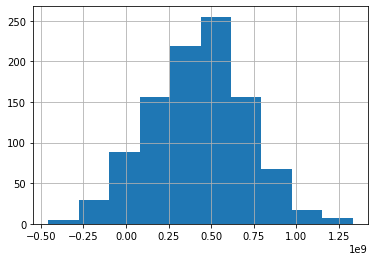

In [75]:
df3_values.hist()

In [76]:
print('Риск получить убыток:{:.1%}'.format(df1_values[df1_values<0].shape[0]/df1_values.shape[0]))
print('Риск получить убыток:{:.1%}'.format(df2_values[df2_values<0].shape[0]/df2_values.shape[0]))
print('Риск получить убыток:{:.1%}'.format(df3_values[df3_values<0].shape[0]/df3_values.shape[0]))

Риск получить убыток:6.0%
Риск получить убыток:0.3%
Риск получить убыток:7.6%


С помощью bootstrap рассчитал распределение прибыли по регонам. Лучший регион 2 с размером прибыли 518 млн рублей.
Риск в регионе 2 0,3%, в остальных риски очень велики.